## A simple use case - prediciting Amazon stock prices using the randomized signature of correlated paths

In [37]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from timeit import default_timer as timer
import math
import pandas as pd
from datetime import datetime
from datetime import date

In [38]:
def sigmoid(x):
  return 1 / (1 + math.exp(-x))

sigm_v = np.vectorize(sigmoid)

def scaling(d, M):
    r = 1
    for i in range(d):
        r += M ** (i+1)
    return r

In [39]:
def process_df(path):
    df = pd.read_csv(path)
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.set_index('Date')
    start = date.fromisoformat('2022-06-24')
    end = date.fromisoformat('2023-06-23')
    new_dates = pd.date_range(start=start,end=end,freq='D')
    df = df.reindex(new_dates)
    assert( len(df) == 365 )
    df["Open"] = df["Open"].interpolate()
    df["Open"] =( df["Open"] - df["Open"].mean() ) / df["Open"].std()
    return(df["Open"])

## Short intro

We are ready to present a simple example how the techniques discussed can be applied in industry. As an arbitrarily chosen trajectory, we will build a simple forecast algorithm for the stock price of Amazon. In other words, this will be our target.

For controls, we choose 20 other publicly available trajectories at Yahoo Finance. All of the data is expressed in daily frequencies (much more precision could presumably be achieved if more frequent data were available). We consider a year long interval, i.e. 365 days starting from 24/06/2022 to 23/06/2023.


Taking the notation from Yahoo Finance, the official name of the target trajectory is

- Amazon.com, Inc. (AMZN)

and the other considered trajectories are as follows:


- Nikkei 225 (N225)
- NASDAQ 100 (NDX)}
- NYSE COMPOSITE (DJ) (NYA)
- S\&P 500 INDEX (SPX)
- Treasury Yield 10 Years (TNX)
- CBOE Volatility Index (VIX)
- PHLX GOLD and SILVER SECTOR I (XAU)
- NYSE ARCA OIL and GAS INDEX (XOI)
- CSI 300 Index (000300.SS)
- Bitcoin USD (BTC-USD)
- Invesco S\&P Global Water Index ETF (CGW)
- Global X DAX Germany ETF (DAX)
- USD/EUR (EURUSD=X)
- SPDR EURO STOXX 50 ETF (FEZ)
- USD/GBP (GBPUSD=X)
- Index Funds S\&P 500 Equal Weight (INDEX)
- MSCI Emerging Markets Index Fut (MME=F)
- USD/JPY (JPY=X)
- Vanguard Real Estate Index Fund (VGSLX)
- Vanguard Total Stock Market Index Fund (VTI)


## Import, clean and preprocess finance data

In [40]:
file_paths = [r'datasets\cov_^N225.csv', r'datasets\cov_^NDX.csv', r'datasets\cov_^NYA.csv',
             r'datasets\cov_^SPX.csv', r'datasets\cov_^TNX.csv', r'datasets\cov_^VIX.csv',
             r'datasets\cov_^XAU.csv', r'datasets\cov_^XOI.csv', r'datasets\cov_000300.SS.csv',
             r'datasets\cov_BTC-USD.csv', r'datasets\cov_CGW.csv', r'datasets\cov_DAX.csv',
             r'datasets\cov_EURUSD=X.csv', r'datasets\cov_FEZ.csv', r'datasets\cov_GBPUSD=X.csv',
              r'datasets\cov_INDEX.csv', r'datasets\cov_MME=F.csv', r'datasets\cov_USDJPY=X.csv', 
              r'datasets\cov_VGSLX.csv', r'datasets\cov_VTI.csv'
             ]
amazon_file_path = r'datasets\target_AMZN.csv'
len(file_paths)

20

In [41]:
df_amzn = pd.read_csv(amazon_file_path)

In [42]:
df_amzn['Date'] = pd.to_datetime(df_amzn['Date'])

In [43]:
df_amzn = df_amzn.set_index('Date')

In [44]:
start = date.fromisoformat('2022-06-24')
end = date.fromisoformat('2023-06-23')

In [45]:
new_dates = pd.date_range(start=start,end=end,freq='D')
df_amzn = df_amzn.reindex(new_dates)

The first thing we do is standardize all data, i.e. we center it around 0 and divide it with its standard deviation. This will prevent issues due to difference in order of magnitude. We can easily recover the actual values by reversing the standardizing, so this does represent any loss of information.

In [46]:
assert( len(df_amzn) == 365 )
df_amzn["Open"] = df_amzn["Open"].interpolate()
df_amzn["Open"] =( df_amzn["Open"] - df_amzn["Open"].mean() ) / df_amzn["Open"].std()
df_amzn.rename(columns={"Open": "amzn"})

df_amzn["amzn"] = df_amzn["Open"]

df_amzn = df_amzn.drop(columns=['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'])

df_amzn

,amzn
2022-06-24,0.254158
2022-06-25,0.355996
2022-06-26,0.457834
2022-06-27,0.559671
2022-06-28,0.326807
...,...
2023-06-19,1.115239
2023-06-20,1.070807
2023-06-21,1.114266
2023-06-22,1.092861


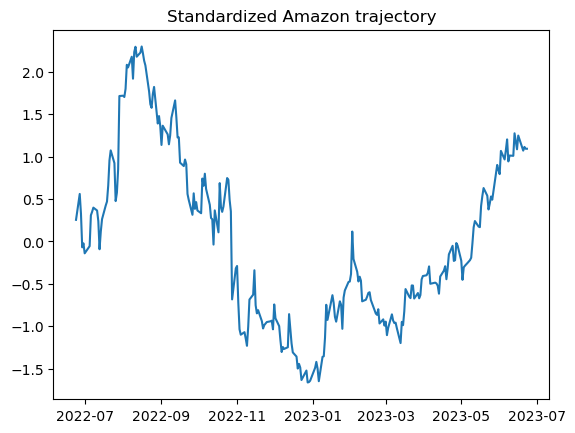

In [47]:
plt.plot(df_amzn.index,df_amzn['amzn'])
plt.title("Standardized Amazon trajectory")
plt.show()

In [48]:
path = file_paths[0]
path

'datasets\\cov_^N225.csv'

In [49]:
process_df(path)

2022-06-24   -1.113145
2022-06-25   -1.005608
2022-06-26   -0.898071
2022-06-27   -0.790535
2022-06-28   -0.756677
                ...   
2023-06-19    3.625187
2023-06-20    3.311538
2023-06-21    3.268215
2023-06-22    3.417387
2023-06-23    3.430168
Freq: D, Name: Open, Length: 365, dtype: float64

In [50]:
i = 1
for path in file_paths:
    df_amzn['cov' + str(i)] = process_df(path)
    i+=1

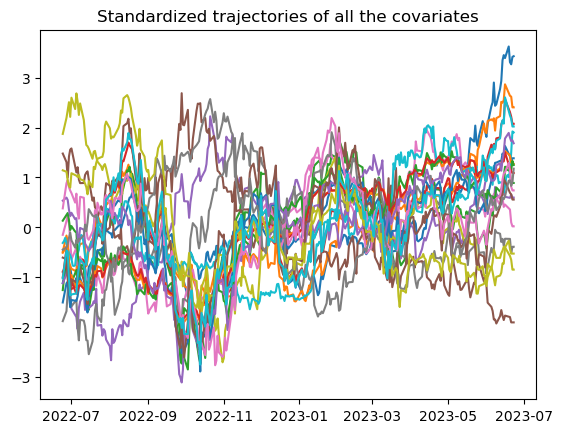

In [51]:
for i in range(1, 21):
    plt.plot(df_amzn.index, df_amzn['cov' + str(i)])
plt.title("Standardized trajectories of all the covariates")
plt.show()

## Switch to generic vector representation

In [52]:
amzn_array = df_amzn['amzn'].to_numpy()
amzn_array.shape

(365,)

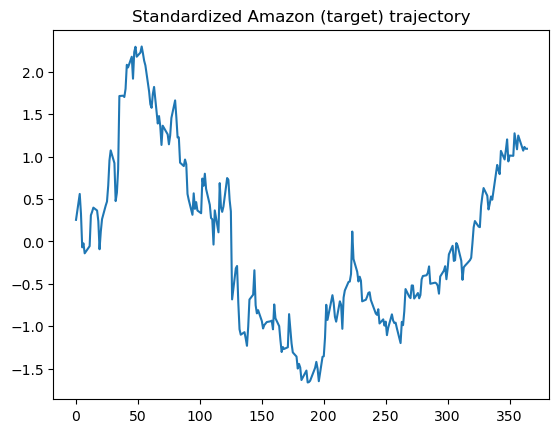

In [53]:
plt.plot(amzn_array)
plt.title("Standardized Amazon (target) trajectory")
plt.show()

In [54]:
cov_array = np.zeros((365, 20))
for i in range(1, 21):
    cov_array[:,i-1] = df_amzn['cov' + str(i)].to_numpy()

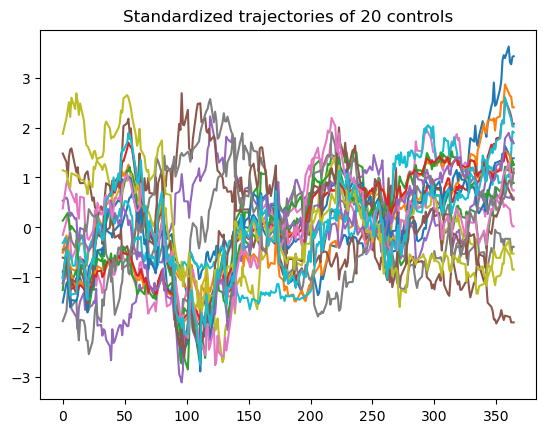

In [55]:
for i in range(1, 21):
    plt.plot(cov_array[:,i-1])
plt.title("Standardized trajectories of 20 controls")
plt.show()

We can now construct the reservoir, i.e. the randomized signature. We have an $\mathbb{R}^{20}$-valued control, $N_{steps}=365$ (days in a year) and we set $N_{train}=330, N_{cv}=15, N_{test}=20$ to be the sizes of the training set, the cross-validation set and the test set, respectively.

## Compute a lower-dimensional randomized signature of the covariate process

In [56]:
k = 2000
A = np.random.normal(0, 1, size=(20, k, k))
b = np.random.normal(0, 1, size=(20,k))
dcov = np.diff(cov_array, axis = 0)
Z = np.zeros((365, k))
Z[0][0] = 1

In [57]:
for i in range(364):
    auxiliary = 0
    for j in range(20):
        auxiliary += (1/10)*sigm_v(A[j]@Z[i] + b[j])*dcov[i][j]
    Z[i+1] = Z[i] + auxiliary

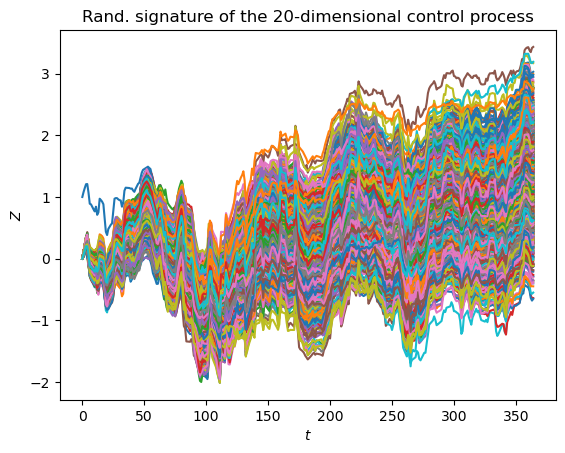

In [58]:
for i in range(k):
    plt.plot(Z[:,i])

plt.title("Rand. signature of the 20-dimensional control process")
plt.xlabel("$t$")
plt.ylabel("$Z$")
plt.show()

## Use to signature to approximate the price of Amazon

#### With cross-validation

In [59]:
days_for_training, days_for_cv = 330, 15

In [60]:
model1 = Ridge(alpha=5).fit(Z[:days_for_training,], amzn_array[:days_for_training,])

In [61]:
r_sq_1 = model1.score(Z[:days_for_training,], amzn_array[:days_for_training,])
print(f"coefficient of determination: {r_sq_1}")

coefficient of determination: 0.9925002117275797


In [62]:
print(f"intercept: {model1.intercept_}")

intercept: 0.282616823212092


In [63]:
#print(f"coefficients: {model1.coef_}")

In [64]:
amzn_pred_1 = model1.predict(Z)

In [65]:
range(30,200)

range(30, 200)

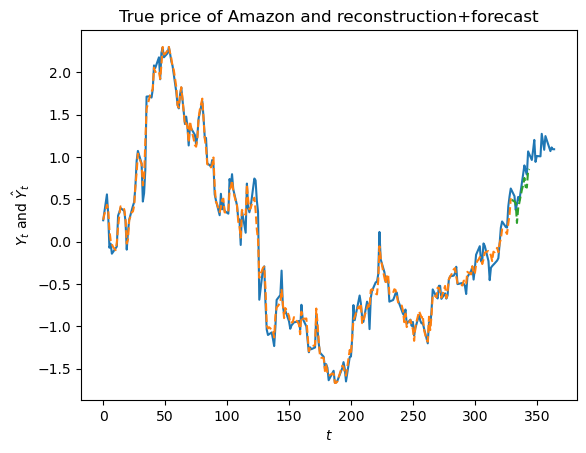

In [66]:
plt.plot(range(365),amzn_array)
plt.plot(range(days_for_training),amzn_pred_1[0:days_for_training], '--')
plt.plot(range(days_for_training,days_for_training + days_for_cv),amzn_pred_1[days_for_training:days_for_training + days_for_cv], '--')
plt.title("True price of Amazon and reconstruction+forecast")
plt.xlabel("$t$")
plt.ylabel("$Y_t$ and $\hat{Y}_t$")
plt.show()

After cross validation, we decide to set $k = 2000$ and $\lambda_{ridge}=5$ to be the randomized signature dimensionality and ridge regression regularization coefficient, respectively. Due to a very large choice for $k$, we additionally alter the activation function to be $\sigma(x) = \frac{1}{10} \cdot \frac{1}{1+e^{-x}}$, to ensure numerical stability.

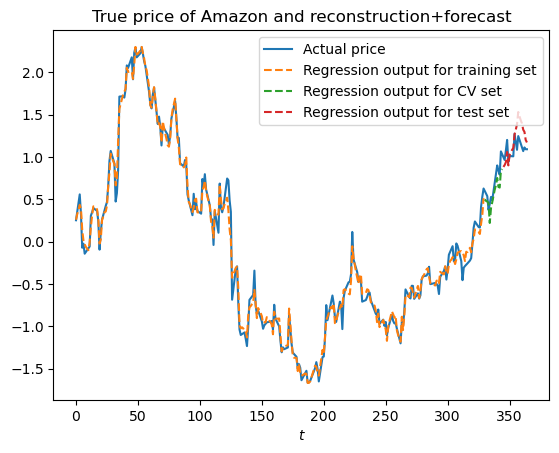

In [67]:
plt.plot(range(365),amzn_array)
plt.plot(range(days_for_training),amzn_pred_1[0:days_for_training], '--')
plt.plot(range(days_for_training,days_for_training + days_for_cv),amzn_pred_1[days_for_training:days_for_training + days_for_cv], '--')
plt.plot(range(days_for_training + days_for_cv, 365) ,amzn_pred_1[days_for_training + days_for_cv:], '--')
plt.title("True price of Amazon and reconstruction+forecast")
plt.xlabel("$t$")
plt.gca().legend(('Actual price','Regression output for training set', 'Regression output for CV set', 'Regression output for test set'))
plt.show()

Finally, after fitting the ridge regression between the randomized signature and target, we obtain some $W_{amzn} \in \mathbb{R}^{2000 \times 1}$ that represents the linear function rule determined by the regression and can be used as a forecasting method, once the randomized signature is at our disposal.

#### The $L^2$ error:

In [68]:
np.linalg.norm(amzn_array[days_for_training + days_for_cv:]-amzn_pred_1[days_for_training + days_for_cv:])/np.linalg.norm(amzn_array[days_for_training + days_for_cv:])

0.16007160538164966